### Direct links to results
[TF-MoDISco results](#tfm-results)

[Summary of motifs](#motif-summary)

[TOMTOM matches to motifs](#tomtom)

[Sample of seqlets for each motif](#seqlets)

In [1]:
import os
from util import import_shap_scores, import_tfmodisco_results, import_peak_table, import_profiles
from util import pfm_to_pwm, trim_motif_by_ic
from util import figure_to_vdom_image
from tomtom import match_motifs_to_database
import viz_sequence
import numpy as np
import h5py
import pandas as pd
import sklearn.cluster
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import vdom.helpers as vdomh
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

/tmp/ipykernel_7543/3602022331.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

## Define constants and paths

In [42]:
# Define parameters/fetch arguments
preds_path = '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/preds'

shap_scores_path = '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_jan23_COUNTS_HEAD/shap_scores' 
tfm_results_path = '/home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_jan23_COUNTS_HEAD/tfmodisco_results'

peak_bed_paths = ['/home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed']
tomtom_database_path = '/home/katie/bp_repo/research/data/HOCOMOCO_JASPAR_motifs.txt'
tfm_motifs_cache_dir = None#'/home/katie/bp_repo/reports/tfm_motif_cache/CTCF/ctcf_chipseq_feb7/'

print("Predictions path: %s" % preds_path)
print("DeepSHAP scores path: %s" % shap_scores_path)
print("TF-MoDISco results path: %s" % tfm_results_path)
print("Peaks path: %s" % peak_bed_paths[0])
print("TOMTOM database path: %s" % tomtom_database_path)
print("Saved TF-MoDISco-derived motifs cache: %s" % tfm_motifs_cache_dir)

Predictions path: /home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_oct10/preds
DeepSHAP scores path: /home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_jan23_COUNTS_HEAD/shap_scores
TF-MoDISco results path: /home/katie/bp_repo/pipeline_outputs/fosl2_chipseq_jan23_COUNTS_HEAD/tfmodisco_results
Peaks path: /home/katie/bp_repo/research/data/chip-seq/CTCF/CTCF.bed
TOMTOM database path: /home/katie/bp_repo/research/data/HOCOMOCO_JASPAR_motifs.txt
Saved TF-MoDISco-derived motifs cache: None


In [4]:
# Define constants
input_length, profile_length = 2114, 1000
shap_score_center_size = 400
profile_display_center_size = 400
hyp_score_key = "hyp_scores"
task_index = None

In [54]:
if tfm_motifs_cache_dir:
    os.makedirs(tfm_motifs_cache_dir, exist_ok=True)

## Helper functions

In [5]:
def extract_profiles_and_coords(
    seqlets_arr, one_hot_seqs, hyp_scores, true_profs, pred_profs, pred_coords,
    input_length, profile_length, input_center_cut_size, profile_center_cut_size,
    task_index=None
):
    """
    From the seqlets object of a TF-MoDISco pattern's seqlets and alignments,
    extracts the predicted and observed profiles of the model, as well as the
    set of coordinates for the seqlets.
    Arguments:
        `seqlets_arr`: a TF-MoDISco pattern's seqlets object array (N-array)
        `one_hot_seqs`: an N x R x 4 array of input sequences, where R is
            the cut centered size
        `hyp_scores`: an N x R x 4 array of hypothetical importance scores
        `true_profs`: an N x T x O x 2 array of true profile counts
        `pred_profs`: an N x T x O x 2 array of predicted profile probabilities
        `pred_coords`: an N x 3 object array of coordinates for the input sequence
            underlying the predictions
        `input_length`: length of original input sequences, I
        `profile_length`: length of profile predictions, O
        `input_center_cut_size`: centered cut size of SHAP scores used
        `profile_center_cut_size`: size to cut profiles to when returning them, P
        `task_index`: index of task to focus on for profiles; if None, returns
            profiles for all tasks
    Returns an N x (T or 1) x P x 2 array of true profile counts, an
    N x (T or 1) x P x 2 array of predicted profile probabilities, an N x Q x 4
    array of one-hot seqlet sequences, an N x Q x 4 array of hypothetical seqlet
    importance scores, and an N x 3 object array of seqlet coordinates, where P
    is the profile cut size and Q is the seqlet length. Returned profiles are
    centered at the same center as the seqlets.
    Note that it is important that the seqlet indices match exactly with the indices
    out of the N. This should be the exact sequences in the original SHAP scores.
    """
    true_seqlet_profs, pred_seqlet_profs, seqlet_seqs, seqlet_hyps, seqlet_coords = [], [], [], [], []
    
    def seqlet_coord_to_profile_coord(seqlet_coord):
        return seqlet_coord + ((input_length - input_center_cut_size) // 2) - ((input_length - profile_length) // 2)
    
    def seqlet_coord_to_input_coord(seqlet_coord):
        return seqlet_coord + ((input_length - input_center_cut_size) // 2)
        
    # For each seqlet, fetch the true/predicted profiles
    for seqlet in seqlets_arr:
        coord_index = seqlet.coor.example_idx
        seqlet_start = seqlet.coor.start
        seqlet_end = seqlet.coor.end
        seqlet_rc = seqlet.coor.is_revcomp
        
        # Get indices of profile to cut out
        seqlet_center = (seqlet_start + seqlet_end) // 2
        prof_center = seqlet_coord_to_profile_coord(seqlet_center)
        prof_start = prof_center - (profile_center_cut_size // 2)
        prof_end = prof_start + profile_center_cut_size
        
        if task_index is None or true_profs.shape[1] == 1:
            # Use all tasks if the predictions only have 1 task to begin with
            task_start, task_end = None, None
        else:
            task_start, task_end = task_index, task_index + 1
            
        true_prof = true_profs[coord_index, task_start:task_end, prof_start:prof_end]  # (T or 1) x P x 2
        pred_prof = pred_profs[coord_index, task_start:task_end, prof_start:prof_end]  # (T or 1) x P x 2
        
        true_seqlet_profs.append(true_prof)
        pred_seqlet_profs.append(pred_prof)
        
        # The one-hot-sequences and hypothetical scores are assumed to already by cut/centered,
        # so the indices match the seqlet indices
        if seqlet_rc:
            seqlet_seqs.append(np.flip(one_hot_seqs[coord_index, seqlet_start:seqlet_end], axis=(0, 1)))
            seqlet_hyps.append(np.flip(hyp_scores[coord_index, seqlet_start:seqlet_end], axis=(0, 1)))
        else:
            seqlet_seqs.append(one_hot_seqs[coord_index, seqlet_start:seqlet_end])
            seqlet_hyps.append(hyp_scores[coord_index, seqlet_start:seqlet_end])
            
        # Get the coordinates of the seqlet based on the input coordinates
        inp_start = seqlet_coord_to_input_coord(seqlet_start)
        inp_end = seqlet_coord_to_input_coord(seqlet_end)
        chrom, start, _ = pred_coords[coord_index]
        seqlet_coords.append([chrom, start + inp_start, start + inp_end])
    
    return np.stack(true_seqlet_profs), np.stack(pred_seqlet_profs), np.stack(seqlet_seqs), np.stack(seqlet_hyps), np.array(seqlet_coords, dtype=object)

In [6]:
def plot_profiles(seqlet_true_profs, seqlet_pred_profs, kmeans_clusters=5, save_path=None):
    """
    Plots the given profiles with a heatmap.
    Arguments:
        `seqlet_true_profs`: an N x O x 2 NumPy array of true profiles, either as raw
            counts or probabilities (they will be normalized)
        `seqlet_pred_profs`: an N x O x 2 NumPy array of predicted profiles, either as
            raw counts or probabilities (they will be normalized)
        `kmeans_cluster`: when displaying profile heatmaps, there will be this
            many clusters
        `save_path`: if provided, save the profile matrices here
    Returns the figure.
    """
    assert len(seqlet_true_profs.shape) == 3
    assert seqlet_true_profs.shape == seqlet_pred_profs.shape
    num_profs, width, _ = seqlet_true_profs.shape

    # First, normalize the profiles along the output profile dimension
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    true_profs_norm = normalize(seqlet_true_profs, axis=1)
    pred_profs_norm = normalize(seqlet_pred_profs, axis=1)

    # Compute the mean profiles across all examples
    true_profs_mean = np.mean(true_profs_norm, axis=0)
    pred_profs_mean = np.mean(pred_profs_norm, axis=0)

    # Perform k-means clustering on the predicted profiles, with the strands pooled
    kmeans_clusters = max(5, num_profs // 50)  # Set number of clusters based on number of profiles, with minimum
    kmeans = sklearn.cluster.KMeans(n_clusters=kmeans_clusters)
    cluster_assignments = kmeans.fit_predict(
        np.reshape(pred_profs_norm, (pred_profs_norm.shape[0], -1))
    )

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the profiles so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)

    # Compute a matrix of profiles, normalized to the maximum height, ordered by clusters
    def make_profile_matrix(flat_profs, order_inds):
        matrix = flat_profs[order_inds]
        maxes = np.max(matrix, axis=1, keepdims=True)
        maxes[maxes == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return matrix / maxes
    true_matrix = make_profile_matrix(true_profs_norm, cluster_inds)
    pred_matrix = make_profile_matrix(pred_profs_norm, cluster_inds)
    
    if save_path:
        np.savez_compressed(
            true_profs_mean=true_profs_mean, pred_profs_mean=pred_profs_mean,
            true_matrix=true_matrix, pred_matrix=pred_matrix
        )

    # Create a figure with the right dimensions
    mean_height = 4
    heatmap_height = min(num_profs * 0.004, 8)
    fig_height = mean_height + (2 * heatmap_height)
    fig, ax = plt.subplots(
        3, 2, figsize=(16, fig_height), sharex=True,
        gridspec_kw={
            "width_ratios": [1, 1],
            "height_ratios": [mean_height / fig_height, heatmap_height / fig_height, heatmap_height / fig_height]
        }
    )

    # Plot the average predictions
    ax[0, 0].plot(true_profs_mean[:, 0], color="darkslateblue")
    ax[0, 0].plot(-true_profs_mean[:, 1], color="darkorange")
    ax[0, 1].plot(pred_profs_mean[:, 0], color="darkslateblue")
    ax[0, 1].plot(-pred_profs_mean[:, 1], color="darkorange")

    # Set axes on average predictions
    max_mean_val = max(np.max(true_profs_mean), np.max(pred_profs_mean))
    mean_ylim = max_mean_val * 1.05  # Make 5% higher
    ax[0, 0].set_title("True profiles")
    ax[0, 0].set_ylabel("Average probability")
    ax[0, 1].set_title("Predicted profiles")
    for j in (0, 1):
        ax[0, j].set_ylim(-mean_ylim, mean_ylim)
        ax[0, j].label_outer()

    # Plot the heatmaps
    ax[1, 0].imshow(true_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
    ax[1, 1].imshow(pred_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
    ax[2, 0].imshow(true_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")
    ax[2, 1].imshow(pred_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")

    # Set axes on heatmaps
    for i in (1, 2):
        for j in (0, 1):
            ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].label_outer()
    width = true_matrix.shape[1]
    delta = 100
    num_deltas = (width // 2) // delta
    labels = list(range(max(-width // 2, -num_deltas * delta), min(width // 2, num_deltas * delta) + 1, delta))
    tick_locs = [label + max(width // 2, num_deltas * delta) for label in labels]
    for j in (0, 1):
        ax[2, j].set_xticks(tick_locs)
        ax[2, j].set_xticklabels(labels)
        ax[2, j].set_xlabel("Distance from seqlet center (bp)")

    fig.tight_layout()
    plt.show()
    return fig

In [7]:
def get_summit_distances(coords, peak_table):
    """
    Given a set of coordinates, computes the distance of the center of each
    coordinate to the nearest summit.
    Arguments:
        `coords`: an N x 3 object array of coordinates
        `peak_table`: a 10-column table of peak data, as imported by
            `import_peak_table`
    Returns and N-array of integers, which is the distance of each coordinate
    midpoint to the nearest coordinate.
    """
    chroms = coords[:, 0]
    midpoints = (coords[:, 1] + coords[:, 2]) // 2
    dists = []
    for i in range(len(coords)):
        chrom = chroms[i]
        midpoint = midpoints[i]
        rows = peak_table[peak_table["chrom"] == chrom]
        dist_arr = (midpoint - rows["summit"]).values
        min_dist = dist_arr[np.argmin(np.abs(dist_arr))]
        dists.append(min_dist)
    return np.array(dists)

In [8]:
def plot_summit_dists(summit_dists):
    """
    Plots the distribution of seqlet distances to summits.
    Arguments:
        `summit_dists`: the array of distances as returned by
            `get_summit_distances`
    Returns the figure.
    """
    fig = plt.figure(figsize=(8, 6))
    num_bins = max(len(summit_dists) // 30, 20)
    plt.hist(summit_dists, bins=num_bins, color="purple")
    plt.title("Histogram of distance of seqlets to peak summits")
    plt.xlabel("Signed distance from seqlet center to nearest peak summit (bp)")
    plt.show()
    return fig

## Import SHAP scores, profile predictions, and TF-MoDISco results

In [43]:
# Import SHAP coordinates and one-hot sequences
hyp_scores, _, one_hot_seqs, shap_coords = import_shap_scores(shap_scores_path, hyp_score_key, center_cut_size=shap_score_center_size, remove_non_acgt=False)
# This cuts the sequences/scores off just as how TF-MoDISco saw them, but the coordinates are uncut


Importing SHAP scores: 100%|████████████████████| 67/67 [00:07<00:00,  8.91it/s]


In [44]:
# Import the set of all profiles and their coordinates
true_profs, pred_profs, all_pred_coords = import_profiles(preds_path)

Importing predictions:   0%|          | 0/67 [00:00<?, ?it/s]

In [45]:
# Import the set of peaks
peak_table = import_peak_table(peak_bed_paths)

In [46]:
# Subset the predicted profiles/coordinates to the task-specific SHAP coordinates/scores
shap_coords_table = pd.DataFrame(shap_coords, columns=["chrom", "start", "end"])
pred_coords_table = pd.DataFrame(all_pred_coords, columns=["chrom", "start", "end"])

subset_inds = pred_coords_table.reset_index().drop_duplicates(["chrom", "start", "end"]).merge(
    shap_coords_table.reset_index(), on=["chrom", "start", "end"]
).sort_values("index_y")["index_x"].values

true_profs = true_profs[subset_inds]
pred_profs = pred_profs[subset_inds]
pred_coords = all_pred_coords[subset_inds]

# Make sure the coordinates all match
assert np.all(pred_coords == shap_coords)

In [47]:
# Import the TF-MoDISco results object
tfm_obj = import_tfmodisco_results(tfm_results_path, hyp_scores, one_hot_seqs, shap_score_center_size)

## Plot some SHAP score tracks
Plot the central region of some randomly selected actual importance scores

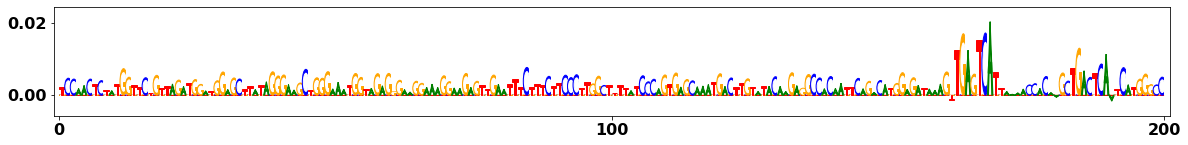

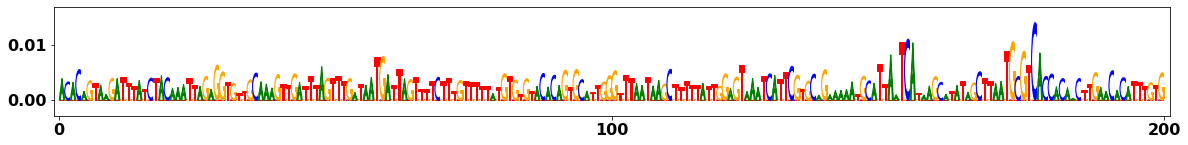

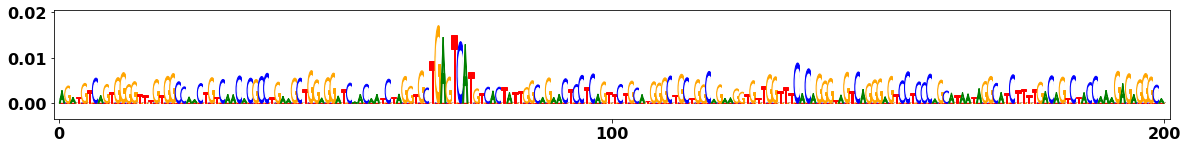

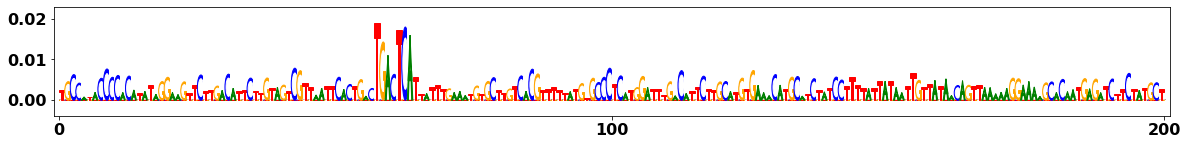

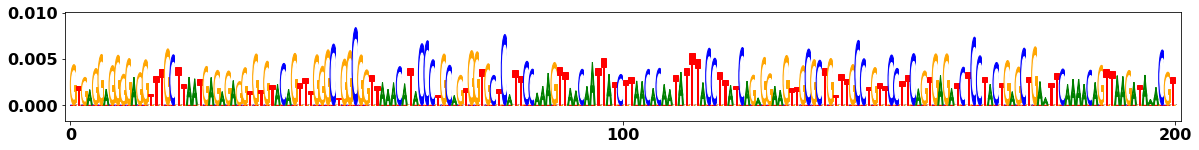

In [48]:
plot_slice = slice(int(shap_score_center_size / 4), int(3 * shap_score_center_size / 4))
for index in np.random.choice(hyp_scores.shape[0], size=5, replace=False):
    viz_sequence.plot_weights((hyp_scores[index] * one_hot_seqs[index])[plot_slice], subticks_frequency=100)

<a id="tfm-results"></a>
## Plot TF-MoDISco results
Plot all motifs by metacluster

<h3>Metacluster 1/1</h3>

<h4>Pattern 1/2</h4>

<p>8950 seqlets</p>

<table><tr><td>Sequence (PFM)</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOydZ3gU1d%2BG79mW7Cah9957EQTp0puAAgIqKogiIE1Esfc/ig2lCagUkS5VpUjv0nvvHUIJpO9m27wfTrLJZDbJbrIJ6Du3116yk9k5U86c8pxfkWRZRkNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQyPQ6B70CWhoaGhoaGhoaGhoaGhoaGhoaGhoaPw30QRoDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ2NbEEToDU0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NLIFTYDW0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDIFjQBWkNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDI1vQBGgNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDY1sQROgNTQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0sgVNgNbQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0MgWNAFaQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0MjW9AEaA0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NjWzB8KBPILMUKFBALlOmzIM%2BDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ2N/1fs37//rizLBX3Z918rQJcpU4Z9%2B/Y96NPQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0Ph/hSRJl33dVwvBoaGhoaGhoaGhoaGhoaGhoaGhoaGhkS1oArSGhoaGhoaGhoaGhoaGhoaGhoaGhka2oAnQGhoaGhoaGhoaGhoaGhoaGhoaGhoa2YImQGtoaGhoaGhoaGhoaGhoaGhoaGhoaGQLmgCtoaGhoaGhoaGhoaGhoaGhoaGhoaGRLWgCtIaGhoaGhoaGhoaGhoaGhoaGhoaGRraQKQFakqSCkiSNlyRptyRJCZIkyYmfoX4cQy9J0huSJB2VJMkqSdJ9SZJWS5LUODPnpKGhoaGhoaGhoaGhoaGhoaGhoaGh8XBhyOTvigPDs1j2bOC5FN%2BDgQ5AG0mSnpJleVUWj6%2BhoaGhoaGhoaGhoaGhoaGhoaGhofEAyWwIjkjgB%2BBZYKq/P5YkqQvJ4vNGoCjQHIhDiOLTJEkyZfLcNDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0HgIyJUDLsnxJluWRsiwvBG5l4hAvpfj3J7Ish8uyvBVYmLitKNA%2BM%2BemoaGhoaGhoaGhoaGhoaGhoaGhoaHxcPCgkhDWT/Hv42n8O%2BU%2BGhoaGhoaGhoaGhoaGhoaGhoaGhoa/zIyGwM6qxRO8e%2BoNP5dKIfOReP/KbIM58/D1atgtUJ8PNjtEBQEFguYzVC2LJQqBZKUtbKsDiuyLGMxWQJz8ukQkxCD2WjGoMve1zvBmUCCK4FcQbmytRyAWHssekmP2WjO9rJyitiEWABCg0KzvayI%2BAhyB%2BfO9jqRozjjIf4axF%2BFhAiQnYAE%2BiAILgohJcX/dfosFeOW3UTZoshrzhuY835IiLRGEhYUhj6L9%2Bf/IzlZJ%2BLscQCEmEJypCyz0YxOygHbBPt9iL0AcVfBZQPcoDNCUCEILQfmYll%2BdwGQ3WC9ATHnIeEOuO0g6UEfDCFlILQ8GAPUBrudEHcJos%2BAM1a0STojmPJDripgLpr1wQQgyzIAUgCO9dDhdkLEbrDdBrcDTHkgXz0IyvegzyzzyDLc2w/W6%2BC0gjEX5K4KoWUf9JlliQsX4NQpiI6G0FAoXx6qVn3QZ/Xw43SKe3f2LMTFie8mE%2BTPD1WqQJEiAWkmSEiA69fFHOfOHTG/kSRRVuHCULIkFCsGRmPWy8oxXHaIOg72e2IM6LKKNt5gBr0ZDGGQuxqYcj/oM/UZtxvOnIGbN8U81GoFhwOCg8U8NCQEKleGQv8mVUSWRV8Ydzn5ObkTQBeU%2BJzMYCkl%2BvosVvZ4RzxOtzNH5qLRCdEEG4Ix6bUosQ8z8Y54XG4XYUFh2V5WlC0Ks9Gs1Qk/edjUiHRbIUmSBgADAEqVKpUjJwSI0cCtzEQa8ROdTvREOcF/sazChSE8PM0/R0bCunWwaxds2QInTohTMyS%2BBbIsPpKU3B/a7aDXQ82a0Lw5NGwIbdsKgdpX3LKbShMrEZUQxe1Rtwk2BGf%2BGjPgUPgh6vxUh5GNRjK23dhsKwegy/wubLiwgVNDT1Exf8VsKyc8NpySP5SkWoFqHBp0yL9Jd069u5Bh/UtJgjOBshPKYnPauPnmTUJN2SdCb7m0hRazWjDssWFM6DjBvx8/LPdPliHyKNzaBDdXw93d4IwRA1lJLyYgHhJfYLdDDHgtpaBIayjcGoq0geACfp3W19u/5v2N77P%2BxfW0Ltfav2vKqfvnR90D2HFlB01nNuWDph8wuvVo/8rKyTrxkPQdqfli6xd8vPljNvfdTPMyzbPttBKcCZQaVwpZlrn55k2CDEHZVtbh8MM88tMjTOgwgWENhgX24LIsRIOba%2BDqErh/SAiNBnPy35OQdInvrh0sJaB4FyjeGQo2S94/PdxOuLsLrv8JV5eJCbDOADpTYjmJZUmS%2BKfLKo6brz6UfgaKdRTl%2BnRdbri7Ey4vgGt/CqFbFyTK87RJSe2RXWwLKw%2Ble0OpnpCrkm/lpKLSxEoEGYI4NviYfz98WNpzb8RdhXNT4ewU8QyRAFnUB5cNinWCKm9AwSZZFiwKfFOAoY8N5dMWn2bpOBkSewHOz4Tzv4AzTlyLnHhN7gQIqwSVhkKpXmrB7CHtOxwO%2BPNP%2BOYbOHJEGGy43aKpdjiE0cbbb0PPnkI8ywrDVg1j%2BanlXB151b8fPmT13OmE7dth/nxYtUrsHhws5hZJ3VvSvCMhQVSRChWgd2/o0QMq%2BdhMXLwIGzbA33/Dtm0QESHKMRiS5zcpy3I4wGYTInSLFtCuHbRpA0XrPET3L/4ahG%2BEO9vh9laIuwA6c3IbkNTOplw0dcZDcCHI3wAKt4RCTaFqh4fmmqKixHP65x/YvBmOHxd1Ib25qM0GYWHw6KPQsiU0biw%2B%2BuIPSTvhiIHwdaI/vL0VIo8DsliABfHvpItKknrcDrE9d3Uo%2BDgUbAhF2vm1eOByu6g5pSZXo65y5Y0rFAktkskLzJiTd05SfXJ1ulbpytJnlvr34//iuDkndSQ/%2Bim37Kbm5Jpcj7nO9ZHXyW/Jn22ndfz2cWpOqUmv6r1Y0GOBfz9%2ByPqpnEaSUw78M3MASfoU%2BCTx6zBZlif58JsrQMnEr/llWb6XuH0kkKSa/U%2BW5Y/TOka9evXkffv2Zfq8/eK/aGXyXyVVfXa54K%2B/YMoUITqbTBAbq9rNJ3Q6YeVht4sVal/5ce%2BPDF01FIC3G7/N122/9r9wH3C5XdSaWosTd05g0Bk4PfQ05fKWy5ayVpxeQZcFXQCoVbgWBwYcyBZLSlmWaTO7DRsvbgRg%2BpPTebnOy74fIKffXR8r1oi/RzB%2B93gAXqj5ArO7z86W04m0RVJxYkXuxt9FL%2BnZ/vJ2GpZo6PsBHvT9s92Bi7PhzETxb9kFblvmjm0IEyLQs77//uL9i1SZVAW7206hkEKcH37ev8WCnLx/PtY9m9NGpYmVuBp9FaPOyMkhJymfr7zv5fxX%2B0Mf79/5e%2Bep9mM17G47RUOLcm74OSzG7PFseWvtW4zdKYZE2bmoKMsyjWc0Zte1XeQJzsP1kdcDc01OK1yaA8dGJ3opZOL9lXRgCBWi5DNxae%2BXEAGnx

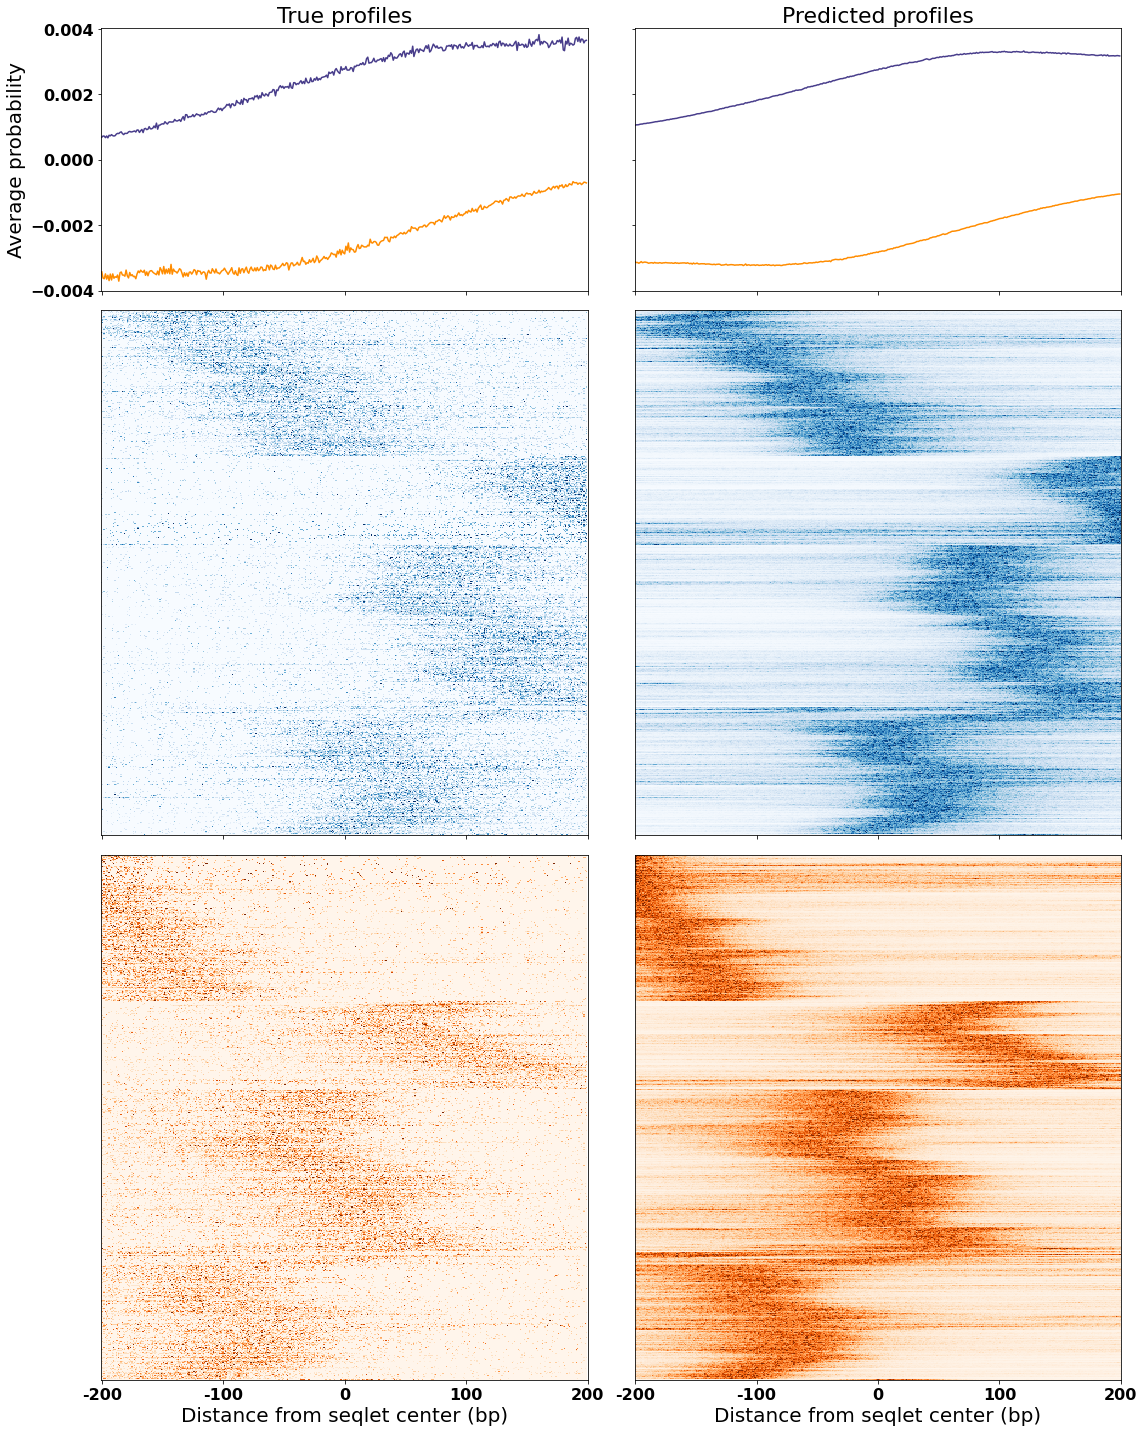

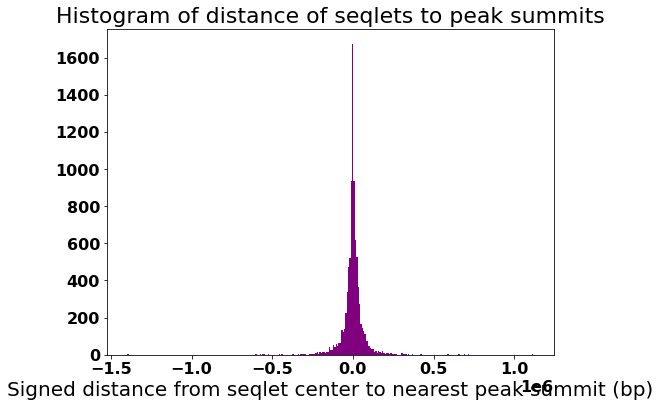

<h4>Pattern 2/2</h4>

<p>70 seqlets</p>

<table><tr><td>Sequence (PFM)</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOydd3wT5R/HP5fRNukAyih7lr23yB6yVGSIC8W9xYnj50RFcS/cCiIiMgUE2Xtvyt6zQFsopSujWc/vjy9Jc7kn%2B5K2eG9feUmuyd3l7rnn%2Be6vwBiDgoKCgoKCgoKCgoKCgoKCgoKCgoKCgtyoSvoEFBQUFBQUFBQUFBQUFBQUFBQUFBQUrk8UA7SCgoKCgoKCgoKCgoKCgoKCgoKCgkJEUAzQCgoKCgoKCgoKCgoKCgoKCgoKCgoKEUExQCsoKCgoKCgoKCgoKCgoKCgoKCgoKEQExQCtoKCgoKCgoKCgoKCgoKCgoKCgoKAQERQDtIKCgoKCgoKCgoKCgoKCgoKCgoKCQkRQDNAKCgoKCgoKCgoKCgoKCgoKCgoKCgoRQTFAKygoKCgoKCgoKCgoKCgoKCgoKCgoRATFAK2goKCgoKCgoKCgoKCgoKCgoKCgoBARFAO0goKCgoKCgoKCgoKCgoKCgoKCgoJCRNCU9AmESqVKlVjdunVL%2BjQUFBQUFBQUFBQUFBQUFBQUFBQUFP5T7Nq1K5sxVjmQz5ZZA3TdunWxc%2BfOkj4NBQUFBQUFBQUFBQUFBQUFBQUFBYX/FIIgnA30s0oJDgUFBQUFBQUFBQUFBQUFBQUFBQUFhYigGKAVFBQUFBQUFBQUFBQUFBQUFBQUFBQigmKAVlBQUFBQUFBQUFBQUFBQUFBQUFBQiAiKAVpBQUFBQUFBQUFBQUFBQUFBQUFBQSEiKAZoBQUFBQUFBQUFBQUFBQUFBQUFBQWFiKAYoBUUFBQUFBQUFBQUFBQUFBQUFBQUFCJCSAZoQRAqC4LwtSAI2wRBKBIEgV17PRPEPtSCILwgCMJ%2BQRBMgiBcFQRhiSAIN4ZyTgoKCgoKCgoKCgoKCgoKCgoKCgoKCqULTYjfqwHg2TCP/QeAu93exwEYCKCfIAi3McYWh7l/BQUFBQUFBQUFBQUFBQUFBQUFBQWFEiTUEhy5AL4EcBeAH4P9siAIt6LY%2BLwaQDUAPQEYQEbxXwVBiAnx3BQUFBQUFBQUFBQUFBQUFBQUFBQUFEoBIRmgGWNnGGMvMsZmAsgKYRcPuP37HcZYJmNsPYCZ17ZVAzAglHNTUFBQUFBQUFBQUFBQUFBQUFBQUFAoHZRUE8KObv8%2B6OXf7p9RUFBQUFBQUFBQUFBQUFBQUFBQUFAoY4RaAzpcUtz%2Bnefl31WidC4RwWoFjh0DTpwATCbaFhcH1K0LNG0KxMaW6OmVCTIygD17gIICQKMBkpOBzp0BvV7e4zgcwO7dwIULgNEIxMfTfWrZEhAEeY8VNRx2IHcfYDgL2E2AKgaIrQRU7Aho5LmAjDEAgBCli8QYcPw4cOQI3Se1GihXDujQgcZGWSU3F9i%2BHcjLo9/o/E0VK8p3DIfDAUEQonavrkcYA/buBc6do/GXmAg0bgykppb0mYUOY8Dhw8DJk0BhIaDTAdWrA%2B3b0/MlJxYLsHUrkJ1N62NiItCmDR2vrOJwALt2ARcv0jqfkEDjoUkT%2BY919WrxPCEINE906gSULy/vcRwOYN8%2B4OxZGudxcUBKCtCxI6DVynusqGLOBq7uBiy5tB7qqtF6KJRUHEb4FBQA27bR2BAEWgdvuEF%2BGSma2Gz0my5donmifPmyv8ZfjzAGHDwInD5Na4deD9SsCbRrJ7/cfOUKsHMnkJ8P2O10rGbNgAYNZD6WvQjI3Q8YzwF2MyBoAG0SUL4VoC/DC9V1RLT1DoDG%2BMGDNM5jYoDKlUkXjZG5UKjRSGv8lSskL%2Bn1QL16QIsWgKqsLlPWQuDqHsB8CXAUAapY0kWT2wHaRFkP5a5LORwkj7VuTfNSWYU3Jho0AJo3l3%2BePX0aOHAAMBhovCUmki5QRUZrnM1hg0YVPdNjdnbx2uEcEy1akI1Hbk6cIPtEYSHZ%2BJzzhNxys9lMYyI7m8ZEfDzQqBG9ypKKX1IGaG/4vHSCIDwG4DEAqF27dlROKFAYA9LSgF9/BZYsAc6fpwGoUtHfgOKBYTQCVasCvXsDjz0GdO167W9VqwJZoVQ0CQGVip7GaJCSAmRmBvTR9HRg5kzg99/J2BgXR6fpvHZFRUCvXsB99wHDhoWuaDEGrFgBTJ8OzJ9ffAzG6P9OIXfkSOCee%2BgeiYjWvQri2sFmAk5PBc7NArK3AoJa/KMAEqqTmgA1hgANnwD0NUI%2BtVdXvIpvd3yLwtcLoYqQEu9wAH//Tfdp7Vq6/xpN8U8SBDL81KoFDBoEPPoo0KqV2w6i%2BUwFca%2Bys4FZs4CpU8nJEhdH2xmjR9NkIgfIffcBd91Fuw6VPHMekj9JxqQhk/BAmweC%2B/L1OCcF80yBHFO//w788AMJuM45XaWixb9%2BfWDMGODOOznGwNI4T4DG3J9/An/9Rb9Jq5XOgcOG0dx3002hCzV2O7B8OTBlCrBoET27QPH1M5vJIfvww8Add4Qv6CZ/nIxRrUZh4qCJ4e3IB4wBmzYBf/xBz7DdXnzdVCoymlWsCIweDYwaRb8vVK5cAWbPpvG3ezc5CJzyBEDXr3174IEHgNtvD91I53DQOjhjBrBsGb13jnPnvbdagW7daD66557iOQtAqR3nYAy4sg04/Blw4V9AHQswt4GuiQeavAA0eBiIDc/jt/LkSgyePhimN0xQq2T23rjhcNBa%2BP33wL//So0gViswdCjw5JN0v0TPbildDwFyePz0E/Djj2SEdn%2BmzGZg8GDgueeAHj3CV7IqfVIJz3R6BuN6jQvui8p6iP37gWnTaP7LyxPLYw4H6T133UWyS%2BfOoZ/W3r3AL78U61POuc99no2LI31g1Cga8yEZ6XIPAMe%2BBTJXAoZzgFp37Q9OxU1Fhml1LFC%2BNVD/AaDOXYBG522PPvk97Xc8/M/DKHy9EHGaOP9fcCda46%2BU6ocAcNfcu7D69GpcfvlyBE%2BKAsimT6dxfvEijWt3XdRmAwYOBO69F7jlltCNTBcvAj//TOvv4cPice58pgCge3eSMe%2B5x%2BNYpXHtvbIDOPYdcGktYLxY/KwwBkAgS4/NBOiqApV7AI2eBip3Cem00tNJj5o9W3r9VCrSGVNSaH647z6Sl1yU0vUwM5NsSfPmkUHYXT90jgmVCujTh8bEyJGhBYwwRjLEtGnA6tVkONVqi2VMpy5arRowYADJ6Z06BX8cJ/uy9qH1j62x%2BeHN6FIztPsdCGlpwKRJ9NsuXOCPiaQk0m3uuw/o3z90mWL//mJd6vLl4uvnPk8MGEBr1JAhoc8TBQU0H82YAWzZUhzE6jyWzUbG9dtuozmiV6/QjhNVGGNhvQCMA63UDMAzAX7nnNt3kt22v%2Bi2/T1f%2B2jfvj0rDdhsjH3/PWN16jCm1zOmVjuHuf%2BXSsVYQgJjKSmMffABC/yLZfEVwHX87DO6hnFx/neXkMBYtWqMrVsX/D07dYqxLl1oH4Lg%2BzhqNWPx8YzdcgtjmZluOylF147ZLYwd%2B4Gx2cmMzdAz9if8v/6KYWyGjrEdzzJmzg7%2BIjLGmnzbhGEc2Nb0rSF93xcOB2MLFzJWvz7dp0CfJ52OsaFDGTtx4tqOStk4dzgY%2B%2BMPxhITaaz7251OR7//55/pu6EwefdkhnFgA/4YEPyXS3reKKlnijFmtzP23ns0H/mbk%2

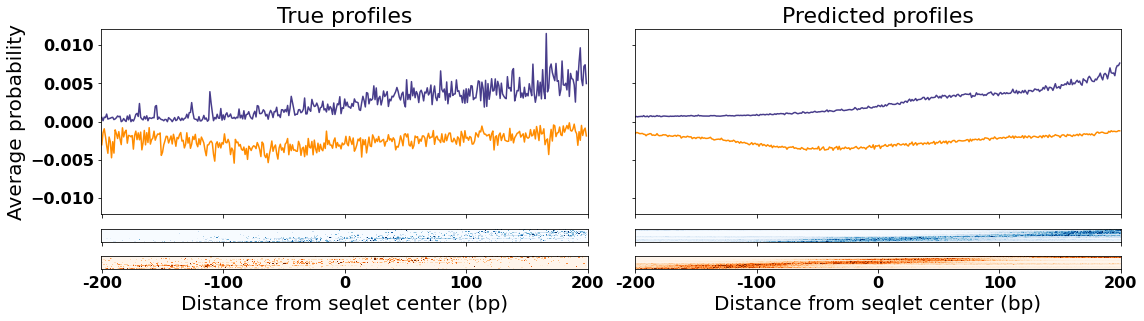

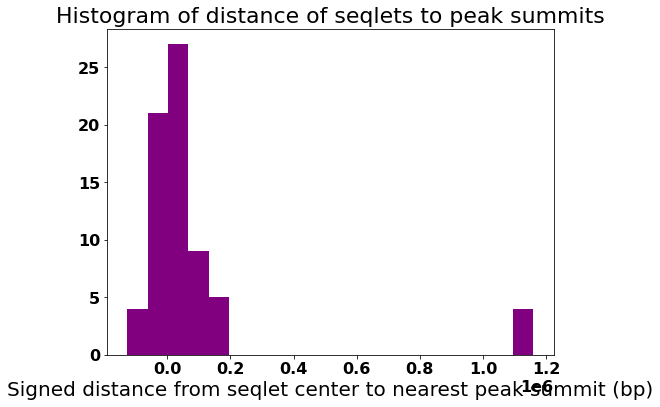

In [49]:
motif_pfms, motif_hcwms, motif_cwms = [], [], []  # Save the trimmed PFMs, hCWMs, and CWMs
motif_pfms_short = []  # PFMs that are even more trimmed (for TOMTOM)
num_seqlets = []  # Number of seqlets for each motif
motif_seqlets = []  # Save seqlets of each motif
if tfm_motifs_cache_dir:
    motif_hdf5 = h5py.File(os.path.join(tfm_motifs_cache_dir, "all_motifs.h5"), "w")
metaclusters = tfm_obj.metacluster_idx_to_submetacluster_results
num_metaclusters = len(metaclusters.keys())
for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
    metacluster = metaclusters[metacluster_key]
    display(vdomh.h3("Metacluster %d/%d" % (metacluster_i + 1, num_metaclusters)))
    patterns = metacluster.seqlets_to_patterns_result.patterns
    if not patterns:
        break
    motif_pfms.append([])
    motif_hcwms.append([])
    motif_cwms.append([])
    motif_pfms_short.append([])
    num_seqlets.append([])
    motif_seqlets.append([])
    num_patterns = len(patterns)
    for pattern_i, pattern in enumerate(patterns):
        seqlets = pattern.seqlets
        display(vdomh.h4("Pattern %d/%d" % (pattern_i + 1, num_patterns)))
        display(vdomh.p("%d seqlets" % len(seqlets)))
        
        pfm = pattern["sequence"].fwd
        hcwm = pattern["task0_hypothetical_contribs"].fwd
        cwm = pattern["task0_contrib_scores"].fwd
        
        pfm_fig = viz_sequence.plot_weights(pfm, subticks_frequency=10, return_fig=True)
        hcwm_fig = viz_sequence.plot_weights(hcwm, subticks_frequency=10, return_fig=True)
        cwm_fig = viz_sequence.plot_weights(cwm, subticks_frequency=10, return_fig=True)
        pfm_fig.tight_layout()
        hcwm_fig.tight_layout()
        cwm_fig.tight_layout()
        
        motif_table = vdomh.table(
            vdomh.tr(
                vdomh.td("Sequence (PFM)"),
                vdomh.td(figure_to_vdom_image(pfm_fig))
            ),
            vdomh.tr(
                vdomh.td("Hypothetical contributions (hCWM)"),
                vdomh.td(figure_to_vdom_image(hcwm_fig))
            ),
            vdomh.tr(
                vdomh.td("Actual contributions (CWM)"),
                vdomh.td(figure_to_vdom_image(cwm_fig))
            )
        )
        display(motif_table)
        plt.close("all")  # Remove all standing figures
        
        # Trim motif based on information content
        short_trimmed_pfm = trim_motif_by_ic(pfm, pfm)
        motif_pfms_short[-1].append(short_trimmed_pfm)
        
        # Expand trimming to +/- 4bp on either side
        trimmed_pfm = trim_motif_by_ic(pfm, pfm, pad=4)
        trimmed_hcwm = trim_motif_by_ic(pfm, hcwm, pad=4)
        trimmed_cwm = trim_motif_by_ic(pfm, cwm, pad=4)
        
        motif_pfms[-1].append(trimmed_pfm)
        motif_hcwms[-1].append(trimmed_hcwm)
        motif_cwms[-1].append(trimmed_cwm)
        
        num_seqlets[-1].append(len(seqlets))
        
        seqlet_true_profs, seqlet_pred_profs, seqlet_seqs, seqlet_hyps, seqlet_coords = extract_profiles_and_coords(
            seqlets, one_hot_seqs, hyp_scores, true_profs, pred_profs, pred_coords,
            input_length, profile_length, shap_score_center_size,
            profile_display_center_size, task_index=task_index
        )
        
        motif_seqlets[-1].append((seqlet_seqs, seqlet_hyps))

        assert np.allclose(np.sum(seqlet_seqs, axis=0) / len(seqlet_seqs), pattern["sequence"].fwd)
        # ^Sanity check: PFM derived from seqlets match the PFM stored in the pattern
        prof_fig = plot_profiles(
            # Flatten to NT x O x 2
            np.reshape(seqlet_true_profs, (-1, seqlet_true_profs.shape[2], seqlet_true_profs.shape[3])),
            np.reshape(seqlet_pred_profs, (-1, seqlet_pred_profs.shape[2], seqlet_pred_profs.shape[3]))
        )
        
        summit_dists = get_summit_distances(seqlet_coords, peak_table)
        dist_fig = plot_summit_dists(summit_dists)
        
        if tfm_motifs_cache_dir:
            # Save results and figures
            motif_id = "%d_%d" % (metacluster_i, pattern_i)
            np.savez_compressed(
                os.path.join(tfm_motifs_cache_dir, motif_id + "_seqlets"),
                seqlet_true_profs=seqlet_true_profs, seqlet_pred_profs=seqlet_pred_profs,
                seqlet_seqs=seqlet_seqs, seqlet_hyps=seqlet_hyps, seqlet_coords=seqlet_coords,
                summit_dists=summit_dists
            )
            prof_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_profiles.png"))
            dist_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_summitdists.png"))
            pfm_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_pfm_full.png"))
            hcwm_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_hcwm_full.png"))
            cwm_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_cwm_full.png"))
            motif_dset = motif_hdf5.create_group(motif_id)
            motif_dset.create_dataset("pfm_full", data=pfm, compression="gzip")
            motif_dset.create_dataset("hcwm_full", data=hcwm, compression="gzip")
            motif_dset.create_dataset("cwm_full", data=cwm, compression="gzip")
            motif_dset.create_dataset("pfm_trimmed", data=trimmed_pfm, compression="gzip")
            motif_dset.create_dataset("hcwm_trimmed", data=trimmed_hcwm, compression="gzip")
            motif_dset.create_dataset("cwm_trimmed", data=trimmed_cwm, compression="gzip")
            motif_dset.create_dataset("pfm_short_trimmed", data=short_trimmed_pfm, compression="gzip")
if tfm_motifs_cache_dir:
    motif_hdf5.close()

<a id="motif-summary"></a>
## Summary of motifs

Motifs are trimmed based on information content, and presented in descending order by number of supporting seqlets. The motifs are separated by metacluster. The motifs are presented as hCWMs. The forward orientation is defined as the orientation that is richer in purines.

In [50]:
colgroup = vdomh.colgroup(
    vdomh.col(style={"width": "5%"}),
    vdomh.col(style={"width": "5%"}),
    vdomh.col(style={"width": "45%"}),
    vdomh.col(style={"width": "45%"})
)
header = vdomh.thead(
    vdomh.tr(
        vdomh.th("#", style={"text-align": "center"}),
        vdomh.th("Seqlets", style={"text-align": "center"}),
        vdomh.th("Forward", style={"text-align": "center"}),
        vdomh.th("Reverse", style={"text-align": "center"})
    )
)

for i in range(len(motif_hcwms)):
    display(vdomh.h3("Metacluster %d/%d" % (i + 1, num_metaclusters)))
    body = []
    for j in range(len(motif_hcwms[i])):
        motif = motif_hcwms[i][j]
        if np.sum(motif[:, [0, 2]]) > 0.5 * np.sum(motif):
            # Forward is purine-rich, reverse-complement is pyrimidine-rich
            f, rc = motif, np.flip(motif, axis=(0, 1))
        else:
            f, rc = np.flip(motif, axis=(0, 1)), motif
            
        f_fig = viz_sequence.plot_weights(f, figsize=(20, 4), return_fig=True)
        f_fig.tight_layout()
        rc_fig = viz_sequence.plot_weights(rc, figsize=(20, 4), return_fig=True)
        rc_fig.tight_layout()
        
        if tfm_motifs_cache_dir:
            # Save results and figures
            motif_id = "%d_%d" % (i, j)
            f_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_hcwm_trimmed_fwd.png"))
            rc_fig.savefig(os.path.join(tfm_motifs_cache_dir, motif_id + "_hcwm_trimmed_rev.png"))

        body.append(
            vdomh.tr(
                vdomh.td(str(j + 1)),
                vdomh.td(str(num_seqlets[i][j])),
                vdomh.td(figure_to_vdom_image(f_fig)),
                vdomh.td(figure_to_vdom_image(rc_fig))
            )
        )
    display(vdomh.table(colgroup, header, vdomh.tbody(*body)))
    plt.close("all")

<h3>Metacluster 1/1</h3>

<table><colgroup><col style="width: 5%"></col><col style="width: 5%"></col><col style="width: 45%"></col><col style="width: 45%"></col></colgroup><thead><tr><th style="text-align: center">#</th><th style="text-align: center">Seqlets</th><th style="text-align: center">Forward</th><th style="text-align: center">Reverse</th></tr></thead><tbody><tr><td>1</td><td>8950</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAAD33UlEQVR4nOydd3wc1dm2r5ntWlXLttxtbAPGxphieg0QWiChtxASEvImeXkJqSRfeqW3EEIqvQcILfQSBzAGXLCNbWzcm2zJsvquts2c74%2Bzo13JKrurVX%2Bu3%2B9oVrNTzs7Onpm5z3Pux1BKIQiCIAiCIAiCIAiCIAiCIAj5xuzvCgiCIAiCIAiCIAiCIAiCIAhDExGgBUEQBEEQBEEQBEEQBEEQhF5BBGhBEARBEARBEARBEARBEAShVxABWhAEQRAEQRAEQRAEQRAEQegVRIAWBEEQBEEQBEEQBEEQBEEQegURoAVBEARBEARBEARBEARBEIReQQRoQRAEQRAEQRAEQRAEQRAEoVcQAVoQBEEQBEEQBEEQBEEQBEHoFUSAFgRBEARBEARBEARBEARBEHoFEaAFQRAEQRAEQRAEQRAEQRCEXsHd3xUYyIwcOVJNmTKlv6shCIIgCIIgCIIgCIIgCIIwYFi8eHGNUmpUJsuKAN0FU6ZMYdGiRf1dDUEQBEEQBEEQBEEQBEEQhAGDYRibM11WLDgEQRAEQRAEQRAEQRAEQRCEXkEEaEEQBEEQBEEQBEEQBEEQBKFXEAFaEARBEARBEARBEARBEARB6BVEgBYEQRAEQRAEQRAEQRAEQRB6hT4VoA3DGGEYxh2GYWw2DCNqGEalYRj3GoYxMcP1XYZhfNcwjI8Nw2gxDKPOMIyXDcM4qt1yUwzDuNEwjAXJfUST%2B3zOMIzDeufTCYIgCIIgCIIgCIIgCIIgCOkYSqm%2B2ZFhlADvAzM6eHsHcKRSqsvsiYZhPApc0sFbCeALSqmXkstdDDzWyWZs4Dyl1LPd1Xnu3Llq0aJF3S0mCIIgCIIgCIIgCIIgCIIwbDAMY7FSam4my/ZlBPQvSInPNwHlwLeT/48Fbu1qZcMwziIlPr%2BVXOd4IAS4gX8YhuFNW%2BU94HygFBhDSpA2gd/04HMIgiAIgiAIgiAIgiAIgiAIGdAnEdCGYRjALrToHAbKlFKx5HvrganoKObRSqm6TrbxNHBu8t9jlVLvJuffA3w1Of/zSqkXDMMoUko1tVt/ZLIOAFGllL%2B7eksEtCAIgiAIgiAIgiAIgiAIQlsGYgT0XmjxGWCdIz4nWZmcuoGDutjGoR2s0/71oQDtxeck6YLz1i5rKwiCIAiCIAiCIAiCIAiCIPSYvhKgK9JeN7R7L/3/0TlsI9P1r0t7/ZculhMEQRAEQRAEQRAEQRAEQRDyQF96QHeG0ZvrG5o/Al9KznoWuL2L5f/HMIxFhmEs2rVrV2eLCYIgCIIgCIIgCIIgCIIgCN3QVwJ0Vdrr0nbvFae9rs5hG52ubxiGB3gY%2BL/krGeBi5RSdmc7UUr9TSk1Vyk1d9SoUV1URxAEQRAEQRAEQRAEQRAEQeiKvhKgNwK7k6%2BnG4bhTXtvVnKaAD7qYhsL017P7GD9NssYhhFAC86XJmfdA5zfzn9aEARBEARBEARBEARBEARB6CX6RIBWSinggeS/AeC3hmGUGYZxNTA1Of85pVSdYRgnGIahkuX%2BtM2kv/61YRgVhmEcD1yUnLcDeBXAMIxS4HXgjOR71ymlrlRKWfn%2BbIIgCIIgCIIgCIIgCIIgCELH9KUH9G%2BA1cnX1wK1wJ3J/3cC3%2B9qZaXUC8BjyX9PTK4zDwiio6e/nhbdfDZwdNrqP0kTtZ0ypUefRhAEQRAEQRAEQRAEQRAEQeiSPhOglVINaFH4TmALEEeLyPcDhymlNmewmcuB7wErgCjQALwCHK%2BUerEXqi0IgiAIgiAIgiAIgiAIgiDkiKHdMYSOmDt3rlq0aFF/V0MQBEEQBEEQBEEQBEEQBGHAYBjGYqXU3EyW7UsLDkEQBEEQBEEQBEEQBEEQBGEY4e7vCgiCIAiCIAiCIAi9TyIBq1fDpk1QWanL%2BvWwYwfEYvp9lwvcbhgxAqZOhYkTYdw4GD8eZs%2BGwsL%2B/hSCIAiCIAw2RIAWBEEQBEEQBEEYglRWwhtvwPz58O67sG4d%2BHxgGFpsbmmB7hwZfT7wevU6LS0wejQceigcf7wuBx6o3xMEQRAEQegMEaAFQRAEQRAEQRCGAErBihXwzDPw6KM60tnjgebm1DKxWHbbjEZ1cdi%2BXZeXX9bb9nrh7LPhwgvhhBO0YC0IgiAIgpCOCNCCIAiCIAj9ibIhuhsiO6FlB0RrwI6DSoDhAsMNnmIIjAX/GPBXgMvb37UWBGEA0dgIDzwAN98Mu3fr6GZHaE4Xj/NJujB9333w1FN6v1/%2BMnz3u7D33r2zX0EQBEEQBh8iQAuCIAiCIPQVLTuhdgnULYHqt6FuGcR2a5HZTI6LVzZggwIM9B8jmTfaToAVAXcQiveFUUdD%2BeFQdhAU75NaThCEYcEnn2jR%2BfHHdfMRDvdPPZTSIjjAP/6hBemDDoIf/xjOOkssOgRBEARhuGOo7ky/hjFz585VixYt6u9qCIIgCIIwWLETUPMebH0Wtj4NkSpw%2BSER0hHOPcYAdyGtavXYU2HSBXrqLcnD9gVBGIhs2QLXXgvPPQfxOFhWf9eoYwoLYcIEuOsuOOmk/q6NIAiCIAj5xDCMxUqpuRktKwJ054gALQiCIAhC1igFuz%2BA1X%2BA7c/r6GYrBKqPFCJ3EdhRHRW973dg4jngElNWQRgK7N4Nv/oV3HOPtruIx/u7RplRUKCTFf7xj3Dwwf1dG0EQBEEQ8oEI0HlCBGhBEARBEDIm1gCbHoZPboVoNSRaALt/6%2BQu0tOpV8A%2B/wfFYsoqCIOVJ5%2BEK6/cMyngYMEwwO%2BHK66AP/2pv2sjCIIgCEJPEQE6T4gALQiCIAhCt8Sb4JNbtPCMAqufTFi7wvCA6YIxp8BBN2n/aEEQBgW7dmnRdt48CIX6uzY9JxDoP69qQRAEQRDyRzYCtCQhFARBEARByIVEGD79I6z4vfZztlr6u0ado%2BJgxaHyRdj5Gow/Gw68Hgqn9HfNBEHoghdfhC9%2BEVpaIBbr79rkh5YB3FQKgiAIgtA7SKp0QRAEQRCEbKl8GZ6bDB//BhJNA1t8TkdZYEVg61Pw4kxY9ov%2BrpEgCB2gFPz2t3DBBdDQMHTEZ0EQBEEQhiciQAuCIAiCIGRKpAbePg/eOR%2BiNQPTbiMTnIjt1bf2d00EQWhHSwucfz7ccINECwuCIAiCMDQQCw5BEARBEIRM2PoMvP8VHUFsD5FwxMEqoAvCEKWmBk44ATZsEPFZEARBEIShgwjQgiAIgiAIXWFbsPRaWPsXEWwFQeg1qqrgyCNh2zaIx/u7NoIgCIIgCPlDBGhBEARBEITOiNbC21%2BA2iUiPguC0Gvs2gWHH

<a id="tomtom"></a>
## Top TOMTOM matches for each motif

Here, the TF-MoDISco motifs are plotted as hCWMs, but the TOMTOM matches are shown as PWMs.

<h3>Metacluster 1/1</h3>

<h4>Motif 1/2</h4>

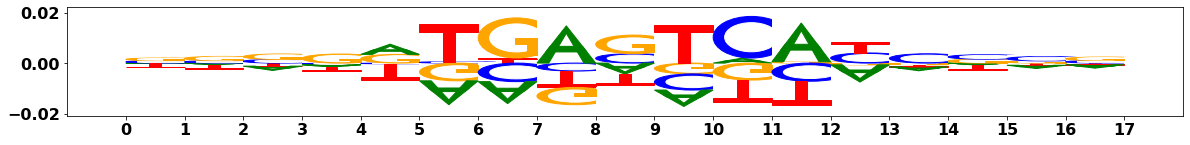

<table><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">q-val</th><th style="text-align: center">PWM</th></tr></thead><tbody><tr><td>JUN_HUMAN.H11MO.0.A</td><td>5.79706e-08</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAABajUlEQVR4nO3dd3xb1f3/8dfR8oyz40BCElYgBMggFCibMsKGllGgA9oCBQrlS3d/LW2hg0ILlJY9CpS9yobSssoIhbASQiCDTJI4y/Eeku75/XEkW3bsWLavLMl%2BPx%2BPmytdXR2dWNK9up/7uZ9jrLWIiIiIiIiIiIiIiPgtkO0OiIiIiIiIiIiIiEj/pAC0iIiIiIiIiIiIiGSEAtAiIiIiIiIiIiIikhEKQIuIiIiIiIiIiIhIRigALSIiIiIiIiIiIiIZoQC0iIiIiIiIiIiIiGSEAtAiIiIiIiIiIiIikhEKQIuIiIiIiIiIiIhIRigALSIiIiIiIiIiIiIZoQC0iIiIiIiIiIiIiGREqLtPMMYcA5wMfAEYDYSBpcDTwJXW2o1dtTFixAg7YcKE7r60iIiIiIiIiIiIiGTZu%2B%2B%2Bu95aOzKddY21tluNG2OeB47o5OElwDRrbdWW2pgxY4adPXt2t15XRERERERERERERLLPGPOutXZGOuv2pARHE3ADsAdQBOwNrEw8ti3w7R60KSIiIiIiIiIiIiL9TLdLcABfs9bWpNz/nzHmL8BVifsTe98tEREREREREREREcl33c6Abhd8TipMub2i590RERERERERERERkf6iJyU42jDGbAV8L3G3Hri7t22KiIiIiIiIiIiISP7rVQDaGLMN8BJQDnjAN621HWZAG2POMcbMNsbMXrduXW9eVkRERERERERERETyQI8D0MaYnYE3gJ2BGPB1a%2B0jna1vrb3FWjvDWjtj5MiRPX1ZEREREREREREREckTPRmEEGPMDOA5YASu7MbJ1tpn/eyYiIiIiIiIiIiIiOS3bgegjTGHAI8Dg4ANwDHW2rd87peIiIiIiIiIiIiI5LmelOC4FBd8BhgOzDLG2JTpFd96JyIiIiIiIiIiIiJ5q1eDEIqIiIiIiIiIiIiIdKbbJTistQdloB8iIiIiIiIiIiIi0s8oA1pEREQkx0XjUdbVrct2N0RERERERLpNAWgRERGRHPfNx7/JqD%2BN4j%2Bf/SfbXREREUnLA3Mf4IzHzsBam%2B2uiIhIlikALSIiIpLDHpr3EA/NewiAkx46iZXVK7PcIxERkS1bUrmEM584k/vm3scfXv9DtrsjIiJZpgC0iIiISI5asGEB33riW8RtHIOhLlrHMfcdQzQezXbXREREOtQYa2TmvTNpijcRIMBv//tbXln6Sra7JSIiWaQAtIiIiEgOqo/WM/OemdRH61uWxbwYCzcu5OLnL85ex0RERLbg209%2BmxVVKwAwxtAQa%2BDEB07k8%2BrPs9wzERHJllC2OyAiMmCNHg0VFdnuhaSrvBzWrMl2L2SAsNZy5uNnsrp2NZa2tTPro/Xc%2BeGdHLztwZy0y0lZ6qGkzYtB41porEiZ1kDdCnfbi4KNuvWScy8KWDAhCIQS83DrPDwISsZD0VZQWJ4yjYZwaWb/P9p35ZcBuu%2ByFjwPYjGIx908dQoGIRRyU/vbxmS79/ntlndv4fFPHqch1tBmeW20lqPvO5p3zn6HcDCcpd6JiEi2mGwMCDBjxgw7e/bsPn9dEZGcoiOc/KNBdKSP3DT7Jn7wwg/aZD8bTJtgdEm4hPfOfY%2BJwydmo4sC4MWhZgFUfgD1y11QuX45NKxyQefmSojVQ7DABY4xYGMQb3Lz3goWQiCSaDcO8Ua3bwkPgYIRUDQairaB0kSwumwXGDoVIoN7/prad%2BWffrLv8jyorHTx9IqK1mnVKli2DFaudPc3boTqahd4DgRaJ2Nap2R7yUB1cg5QUgJDh8KoUbD11jBuHGyzjYvljx7t5uXlMHIkhBVHbeO91e%2Bx3x37tQk%2BB02QuI0DUBwu5hu7f4Mbj7kxW10UEREfGWPetdbOSGtdBaBFRLJEB/H5p58cxEtue2/1e%2Bx/x/7Ux%2BrbLG8fgA6YABOGTGDueXMpDhf3dTcHnlgdbJoLle/Dulmw4W2o%2BwwCBYCBeIM/QeVMCRa5IHisASJDYMjuMHI/GDYdhk6D4rHp7Ze078o/ebbvWrcOPvgA3n8f3ngD5s2DDRugpsZlKUciLqDsedDUBM3Nme9TKASFhS5D2lqIRt1rFxW5YPV228G%2B%2B8Iee8DUqbDttq6PA8nGho3scv0uVNS1vUIiNQANLgh9%2B3G389Vdv9rXXRQREZ8pAC0ikg90EJ9/8uwgXvJPZUMlk66ftNkBPGwegAYoChVxzMRjePCkBzHapvinocIFmivfh3WvuwznxrUQLHZlMuINXTaRF0wQQiXgNQMBGDwJRnwRhu/pMqXLdk5kbqc%2BR5%2BzvJOj%2By7Pg88%2Bc8Hm2bPh9dddsLm%2B3gV2Gxr6Jrjsl0AASktbS35MnAj77AN77eWC0pMnQ0FBtnuZGZ71OOSuQ5i1chbN8bZvWvsANLgg9Dtnv8MuI3fpy26KiIjPFIAWEckHOojPPzl6EC/9g2c9Dr37UN5Y8cZmB/DQcQAa3IH81Ydfzbkzzu2LbvZPXhw2vAUrHoNlD0HTOlc2I9bgAs4DinFBaXAZ3aMOhgmnwdZHQcFw7bvyUY7su9asgeefd1nNb70FCxe21l2urW0tgdHflJS4/2N9PYwZ47Kk990XDjsMdt21f3ylfvXyr/jTrD%2B1KRuV1FEA2mAYWzaWeefPY1DBoL7qpoiI%2BEwBaBGRfNAfjjgGmhw5iJf%2B6fJXL%2BeKN67o8AAeOg9Ag8uEfv1brzN9q%2BmZ7GL/Eq2FNS/A0gdg9XO4Mhr1rpaytBUqdVnSZZPg6A%2Bz3Rvpriztu6yFuXPh8cfh/vthyRJXM7m2NivdySkFBS74XlwMJ54IJ53kAtL56F%2BL/sWJD5642aCDSR0FoAEKg4Ucut2hPHnak7qCR0QkTykALSKSD/RjO/8oAC0Z8srSVzjq3qM6PYCHLQegAcpLypl/wXyGFg3NRBf7h7oV8PlTsPRe2Djb1W%2BO1WS7V/nljGx3QLqtD/ddTU3w6qvwyCPw2GPQ2OjqJedTKY2%2BlizdUVWV7Z503/Kq5ex2425UN1V3uk5nAWhwV/D85qDf8MMv/jBTXRQRkQzqTgA6lOnOiIiIiEjnVtes3mL2WLoqGys5%2BeGTeeHrLxAwA2z0qy1pWAMLb4ald0P9KjABl%2BkMidrHItIbGzbAs8/CfffBK6%2B4QQL7c0kNv3keVHcev81ZTbEmjrz3SOqa63rcRn20nktfvpS9x%2B7NfuP287F3IiKSaxSAFhERGeisdVmgTeuhcb2bN29I3F8L0RpXB9eLulq5NgpezNWHxbhBygIhMCF324QgEIGCEVA4ws1Tp8hwCEay/b/OCTEvxjH3HUNtc%2B%2BvSW%2BON/PWyrf4w2t/4P8d8P986F0esxY2/A8%2B/iOset4t8xqz2yeRfsRa%2BPe/4YorXE3nZNAZXNaz9H/nPXMeSyqXdJrdnK6GWAPH3X8cH1/wMaNLR/vUOxERyTUKQIu

<h4>Motif 2/2</h4>

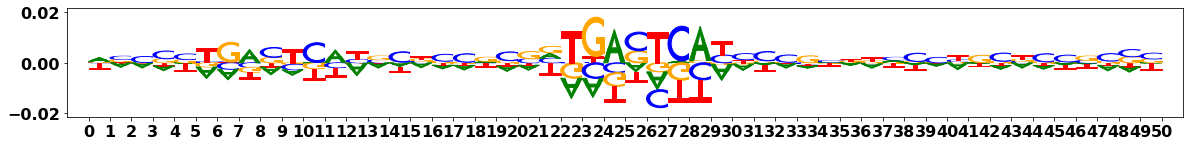

<table><thead><tr><th style="text-align: center">Motif ID</th><th style="text-align: center">q-val</th><th style="text-align: center">PWM</th></tr></thead><tbody><tr><td>MA0478.1_FOSL2</td><td>0.497954</td><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAACQCAYAAAD%2B4szCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAABeHklEQVR4nO3dd5wb1bn/8c8ZtV3tundcMKbbYJoxJkCAUALBQOj1QggJpAG5IckvuZcLAW5uSCUkEFqAQMD03hIIpoVuY2zTjXHDvW7T7qqd3x9HWmnXu/aW0Wq1%2B32/XvOa0UganZW0M5pnnvMcY61FRERERERERERERMRvXrEbICIiIiIiIiIiIiK9kwLQIiIiIiIiIiIiIlIQCkCLiIiIiIiIiIiISEEoAC0iIiIiIiIiIiIiBaEAtIiIiIiIiIiIiIgUhALQIiIiIiIiIiIiIlIQCkCLiIiIiIiIiIiISEEoAC0iIiIiIiIiIiIiBaEAtIiIiIiIiIiIiIgUhALQIiIiIiIiIiIiIlIQwWK86NChQ%2B348eOL8dIiIiIiIiIiIiIi0gWzZ89eZ60d1p7HFiUAPX78eGbNmlWMlxYRERERERERERGRLjDGLGnvY1WCQ0REREREREREREQKQgFoERERERERERERESkIBaBFREREREREREREpCAUgBYRERERERERERGRglAAWkREREREREREREQKosMBaGPMdGPMncaYj4wxG40xtcaY940x1xhjBheikSIiIiIiIiIiIiJSeoKdeM4PgK%2B2WDcpM51qjNnLWlvV5ZaJiIiIiIiIiIiISEnrTAmORuAvwD5AOTAN%2BCJz33bA%2Bf40TURERERERERERERKWWcyoM%2B21tbk3X7LGHMd8NvM7Z263iwRERERERERERERKXUdzoBuEXzOKstbXtb55oiIiIiIiIiIiIhIb9GZEhzNGGNG4epCA8SAu7q6TREREREREREREREpfZ0pwdHEGDMWeA4YAaSBc621rWZAG2MuAC4AGDduXFdeVkRERETyJeuhfgU0rIJUI9gkpJNgE5l55rYXBBPMzEO524EIlI2E8lEQjBb7rxEREZFuVtNYg2c8KsIVxW6KiPRCnQ5AG2N2wQWfxwJJXPD5obYeb629BbgFYMqUKbazrysiIlIUI0fC6tXFboW0x4gRsGpVsVvhj3QC6le54HJ2qlsKtZ9D3RIXcG5cB%2Bk4BMrBBFpswILNzLGAcZMhs5z/0CSkGsALQ2QIlI2CinFQuT1Ex0J0NJRvk5lGghcq/N8vIl2jY1fp6E3HLik5a%2BrWMO7acQwuH8ziHy4mHAgXu0ki0st0KgBtjJkCPAsMxZXdOMVa%2B4yfDRMREelRdAJfOkrxs7IW6pfDurdg7euw5kWoXQiJWgiUuWCvtS7QnG5ofRvJWn/akqqH2Bdu2vCOW%2BeVucC0MS4onmqAUCVUTIARh8KwA2DIVIiOcY8RkZ6hFPeHfZU%2BKymStE1zwv0n0JhqZGXtSn74jx/yl2P%2BUuxmiUgv0%2BEAtDHmK8BjQD9gPTDdWvumz%2B0SERER6b3iVbBhlgs4r/4XbHgX0o0uyJuoxVU2y0jFIFW0ljrphs0D34lq2PQebJoHn9/mguNeBAbvDSMOg6HTYPAUCA8oSpNFRERk6656%2BSreW/UenvFI2zR3zr2TI7c/kq/v8vViN01EehFjbceqYRhjXgIO3sJDXrbWHrKlbUyZMsXOmjWrQ68rIiJSVMrqLC0d/H1TUDYNG%2BfC%2Bjdh1UxY9yY0rHa1lpMxV6e5tzEhCJa72tRlw2Ho/i5Teug0GLQnmC6Pgy0i7aFjV2npSccu6RNeWvwSX7vna9Qn65sC0ACV4UrmfWce2w3arsgtFJGezBgz21o7pT2P7dIghCIiIiLSCpuGdW/A4hmw5D6XHWxTrrxFVqKqeO0rNJuARCawXr8clj0EK552Naq9MIw7FcafBcO%2BpGC0iIhIEayuXc2J959IfbJ%2Bs/tiiRjT753OnAvnqB60iPiiwwHorWU3i4iIiPRJ6RSsew0W3wNLHsgEnGNuLs2D7wtvde%2BTCcApG4vXJhERkT4olU5xwv0nUBtvffyItE2zeNNiLnn2Em6cfmM3t05EeiNlQIuIiIh0lrWw7nVYeDsse9hlPqfq3FzaZlOQrCl2K0RERPqkq16%2Birmr55JIt10GLJaIcde8uzhy%2ByM5YdcTurF1ItIbKQAtIiIi0lHJOlh0N3z4a2hc42odo6CziIhIV1kLqVRuCgYhEADPU1lzP7y46EV%2B%2B/pvWy290VIsEeOcR89h7si5TBg0oRtaJyK9lQLQIiIiIu1VvQA%2BvhYW3enOgpN1xW6RiIhIj5NOw4YNsHo1rFnjptWrYdUqWLoUli93t9evh5oaSCZd4DmddpMxuYBzOu3us9aty06hEAwYAEOHwqhRMGYMjB0LI0fC8OG5acQI6NdPwWtwdZ9PeuCkdgWfs2LJGNNnuHrQkWCkgK0Tkd5MAWgRERGRrdn0Prz3M1j9gqv1bNvusioiItIXpFKwYAHMmwdz5sAbb8DixbBxI9TWQjjsgsSe54LI8Tg0NrZv29ks6JayAWpw26urgxUrXBvABZnLytzrGuO20djotte/PwwZArvuCvvvD3vsAZMnwzbb9I3gdLbuc028YyWw0jbNkqolXPyPi7l5%2Bs0Fap2I9HYKQIuIiIi0pfpTePfSTOC5sWfWdjYeRIZD%2BTYQHe3m5aMgWAFeBLxwZgpBOgHpeGZqdBnc9SuhfoWbYstdSZGe%2BHeWkCtevIKVNSu5%2BdibMX0hqiEivd769S7IO2%2BeCzS/%2B64LNkciLnhbW%2BuCvPkaGtzUnayF%2Bno3tbRhg5sWLIBnn4Vo1AWnAwHYeWfYbz%2BYMsUFpSdNgvLy7m17oV358pXMXT2XZDrZ4efGEjHunnc3X93%2Bq5y464kFaJ2I9HYKQIuIiIi01Lge3v0RLH3QBWttK2lY3ckLwYDdYeh%2BMHgKVGzngs1lwyDYLxdUBhdsDpS5wPTW2DSk6l1gGuNexwu7AQIb1kL9cqhdBBtmwfq3YdO8zGOlLbfNuY2rXrkKgJH9RnLVoVcVuUUiIh3T2AivvALPPQevvw4ffeQyjcvK3H35WcyJEj0kJBJQVZW7/e67bqqocAHpWMyV7pg8GQ46CI46Cvbcs3QzpV9c9CK/e/13HSq90VIsEePcR89lz5F7qh60iHSYsS0vU3aDKVOm2FmzZnX764qIiHRaqZ5x9FWd/X1jLSy6C2ZfDKmGXFC3u1VuD0OmwvCDYPjBULkDpBvABFxmc3dLxlzgOVAOtZ/Bmpdh7b9h3VtQu7Br2z6z%2B3%2BLFspjHz/GmQ%2BfSX2yHs94lAXLuOawa7hov4uK3TTpq3TsKi1FODfPWrYMnnkG7rvPZThHIq42cxGb1GOEw24KBOCYY%2BCkk%2BDEEkoCXlW7il1v2JVNDZu2%2BDjPeKS30gPKMx47DdmJ9y58T/WgRQRjzGxr7ZR2PVYBaBERkXbQSXxp6czvm%2BpP4Y3/gKoPun9wwchQGHsSjD8bBu/p1tk0BCvbl8nc3WwakrUuII6FjXNh0d2w7CFoXNexbfWSAPTLi1/m6HuObsouy57IlwfLue242zhj9zOK3ELpk3T

In [51]:
num_matches_to_keep = 10
num_matches_to_show = 5

header = vdomh.thead(
    vdomh.tr(
        vdomh.th("Motif ID", style={"text-align": "center"}),
        vdomh.th("q-val", style={"text-align": "center"}),
        vdomh.th("PWM", style={"text-align": "center"})
    )
)

for i in range(len(motif_pfms)):
    display(vdomh.h3("Metacluster %d/%d" % (i + 1, num_metaclusters)))
    
    # Compute TOMTOM matches for all motifs in the metacluster at once
    out_dir = os.path.join(tfm_motifs_cache_dir, "tomtom", "metacluster_%d" % i) if tfm_motifs_cache_dir else None
    tomtom_matches = match_motifs_to_database(motif_pfms_short[i], top_k=num_matches_to_keep, database_path=tomtom_database_path, temp_dir=out_dir)
    
    for j in range(len(motif_pfms[i])):
        display(vdomh.h4("Motif %d/%d" % (j + 1, len(motif_pfms[i]))))
        viz_sequence.plot_weights(motif_hcwms[i][j])
    
        body = []
        for k, (match_name, match_pfm, match_qval) in enumerate(tomtom_matches[j]):
            fig = viz_sequence.plot_weights(pfm_to_pwm(match_pfm), return_fig=True)
            fig.tight_layout()
            if k < num_matches_to_show:
                body.append(
                    vdomh.tr(
                        vdomh.td(match_name),
                        vdomh.td(str(match_qval)),
                        vdomh.td(figure_to_vdom_image(fig))
                    )
                )
                if tfm_motifs_cache_dir:
                    # Save results and figures
                    motif_id = "%d_%d" % (i, j)
                    fig.savefig(os.path.join(out_dir, motif_id + ("_hit-%d.png" % (k + 1))))
            else:
                body.append(
                    vdomh.tr(
                        vdomh.td(match_name),
                        vdomh.td(str(match_qval)),
                        vdomh.td("Not shown")
                    )
                )
        if not body:
            display(vdomh.p("No TOMTOM matches passing threshold"))
        else:
            display(vdomh.table(header, vdomh.tbody(*body)))
        plt.close("all")

<a id="seqlets"></a>
## Sample of seqlets supporting each motif
Here, the motifs are presented as hCWMs, along with the actual importance scores of a random sample of seqlets that support the motif.

In [52]:
num_seqlets_to_show = 10

colgroup = vdomh.colgroup(
    vdomh.col(style={"width": "50%"}),
    vdomh.col(style={"width": "50%"})
)

header = vdomh.thead(
    vdomh.tr(
        vdomh.th("Motif hCWM", style={"text-align": "center"}),
        vdomh.th("Seqlets", style={"text-align": "center"})
    )
)

for i in range(len(motif_hcwms)):
    display(vdomh.h3("Metacluster %d/%d" % (i + 1, num_metaclusters)))
    
    for j in range(len(motif_hcwms[i])):
        display(vdomh.h4("Motif %d/%d" % (j + 1, len(motif_hcwms[i]))))
        
        motif_fig = viz_sequence.plot_weights(motif_hcwms[i][j], figsize=(20, 4), return_fig=True)
        motif_fig.tight_layout()
        
        seqlet_seqs, seqlet_hyps = motif_seqlets[i][j]
        
        sample_size = min(num_seqlets_to_show, len(seqlet_seqs))
        sample_inds = np.random.choice(len(seqlet_seqs), size=sample_size, replace=False)
        sample = []
        for k in sample_inds:
            fig = viz_sequence.plot_weights(seqlet_hyps[k] * seqlet_seqs[k], subticks_frequency=10, return_fig=True)
            fig.tight_layout()
            sample.append(figure_to_vdom_image(fig))
        body = vdomh.tbody(vdomh.tr(vdomh.td(figure_to_vdom_image(motif_fig)), vdomh.td(*sample)))
        display(vdomh.table(colgroup, header, body))
        plt.close("all")

<h3>Metacluster 1/1</h3>

<h4>Motif 1/2</h4>

<table><colgroup><col style="width: 50%"></col><col style="width: 50%"></col></colgroup><thead><tr><th style="text-align: center">Motif hCWM</th><th style="text-align: center">Seqlets</th></tr></thead><tbody><tr><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAAD33UlEQVR4nOydd3wc1dm2r5ntWlXLttxtbAPGxphieg0QWiChtxASEvImeXkJqSRfeqW3EEIqvQcILfQSBzAGXLCNbWzcm2zJsvquts2c74%2Bzo13JKrurVX%2Bu3%2B9oVrNTzs7Onpm5z3Pux1BKIQiCIAiCIAiCIAiCIAiCIAj5xuzvCgiCIAiCIAiCIAiCIAiCIAhDExGgBUEQBEEQBEEQBEEQBEEQhF5BBGhBEARBEARBEARBEARBEAShVxABWhAEQRAEQRAEQRAEQRAEQegVRIAWBEEQBEEQBEEQBEEQBEEQegURoAVBEARBEARBEARBEARBEIReQQRoQRAEQRAEQRAEQRAEQRAEoVcQAVoQBEEQBEEQBEEQBEEQBEHoFUSAFgRBEARBEARBEARBEARBEHoFEaAFQRAEQRAEQRAEQRAEQRCEXsHd3xUYyIwcOVJNmTKlv6shCIIgCIIgCIIgCIIgCIIwYFi8eHGNUmpUJsuKAN0FU6ZMYdGiRf1dDUEQBEEQBEEQBEEQBEEQhAGDYRibM11WLDgEQRAEQRAEQRAEQRAEQRCEXkEEaEEQBEEQBEEQBEEQBEEQBKFXEAFaEARBEARBEARBEARBEARB6BVEgBYEQRAEQRAEQRAEQRAEQRB6hT4VoA3DGGEYxh2GYWw2DCNqGEalYRj3GoYxMcP1XYZhfNcwjI8Nw2gxDKPOMIyXDcM4qt1yUwzDuNEwjAXJfUST%2B3zOMIzDeufTCYIgCIIgCIIgCIIgCIIgCOkYSqm%2B2ZFhlADvAzM6eHsHcKRSqsvsiYZhPApc0sFbCeALSqmXkstdDDzWyWZs4Dyl1LPd1Xnu3Llq0aJF3S0mCIIgCIIgCIIgCIIgCIIwbDAMY7FSam4my/ZlBPQvSInPNwHlwLeT/48Fbu1qZcMwziIlPr%2BVXOd4IAS4gX8YhuFNW%2BU94HygFBhDSpA2gd/04HMIgiAIgiAIgiAIgiAIgiAIGdAnEdCGYRjALrToHAbKlFKx5HvrganoKObRSqm6TrbxNHBu8t9jlVLvJuffA3w1Of/zSqkXDMMoUko1tVt/ZLIOAFGllL%2B7eksEtCAIgiAIgiAIgiAIgiAIQlsGYgT0XmjxGWCdIz4nWZmcuoGDutjGoR2s0/71oQDtxeck6YLz1i5rKwiCIAiCIAiCIAiCIAiCIPSYvhKgK9JeN7R7L/3/0TlsI9P1r0t7/ZculhMEQRAEQRAEQRAEQRAEQRDyQF96QHeG0ZvrG5o/Al9KznoWuL2L5f/HMIxFhmEs2rVrV2eLCYIgCIIgCIIgCIIgCIIgCN3QVwJ0Vdrr0nbvFae9rs5hG52ubxiGB3gY%2BL/krGeBi5RSdmc7UUr9TSk1Vyk1d9SoUV1URxAEQRAEQRAEQRAEQRAEQeiKvhKgNwK7k6%2BnG4bhTXtvVnKaAD7qYhsL017P7GD9NssYhhFAC86XJmfdA5zfzn9aEARBEARBEARBEARBEARB6CX6RIBWSinggeS/AeC3hmGUGYZxNTA1Of85pVSdYRgnGIahkuX%2BtM2kv/61YRgVhmEcD1yUnLcDeBXAMIxS4HXgjOR71ymlrlRKWfn%2BbIIgCIIgCIIgCIIgCIIgCELH9KUH9G%2BA1cnX1wK1wJ3J/3cC3%2B9qZaXUC8BjyX9PTK4zDwiio6e/nhbdfDZwdNrqP0kTtZ0ypUefRhAEQRAEQRAEQRAEQRAEQeiSPhOglVINaFH4TmALEEeLyPcDhymlNmewmcuB7wErgCjQALwCHK%2BUerEXqi0IgiAIgiAIgiAIgiAIgiDkiKHdMYSOmDt3rlq0aFF/V0MQBEEQBEEQBEEQBEEQBGHAYBjGYqXU3EyW7UsLDkEQBEEQBEEQBEEQBEEQBGEY4e7vCgiCIAiCIAiCIAi9TyIBq1fDpk1QWanL%2BvWwYwfEYvp9lwvcbhgxAqZOhYkTYdw4GD8eZs%2BGwsL%2B/hSCIAiCIAw2RIAWBEEQBEEQBEEYglRWwhtvwPz58O67sG4d%2BHxgGFpsbmmB7hwZfT7wevU6LS0wejQceigcf7wuBx6o3xMEQRAEQegMEaAFQRAEQRAEQRCGAErBihXwzDPw6KM60tnjgebm1DKxWHbbjEZ1cdi%2BXZeXX9bb9nrh7LPhwgvhhBO0YC0IgiAIgpCOCNCCIAiCIAj9ibIhuhsiO6FlB0RrwI6DSoDhAsMNnmIIjAX/GPBXgMvb37UWBGEA0dgIDzwAN98Mu3fr6GZHaE4Xj/NJujB9333w1FN6v1/%2BMnz3u7D33r2zX0EQBEEQBh8iQAuCIAiCIPQVLTuhdgnULYHqt6FuGcR2a5HZTI6LVzZggwIM9B8jmTfaToAVAXcQiveFUUdD%2BeFQdhAU75NaThCEYcEnn2jR%2BfHHdfMRDvdPPZTSIjjAP/6hBemDDoIf/xjOOkssOgRBEARhuGOo7ky/hjFz585VixYt6u9qCIIgCIIwWLETUPMebH0Wtj4NkSpw%2BSER0hHOPcYAdyGtavXYU2HSBXrqLcnD9gVBGIhs2QLXXgvPPQfxOFhWf9eoYwoLYcIEuOsuOOmk/q6NIAiCIAj5xDCMxUqpuRktKwJ054gALQiCIAhC1igFuz%2BA1X%2BA7c/r6GYrBKqPFCJ3EdhRHRW973dg4jngElNWQRgK7N4Nv/oV3HOPtruIx/u7RplRUKCTFf7xj3Dwwf1dG0EQBEEQ8oEI0HlCBGhBEARBEDIm1gCbHoZPboVoNSRaALt/6%2BQu0tOpV8A%2B/wfFYsoqCIOVJ5%2BEK6/cMyngYMEwwO%2BHK66AP/2pv2sjCIIgCEJPEQE6T4gALQiCIAhCt8Sb4JNbtPCMAqufTFi7wvCA6YIxp8BBN2n/aEEQBgW7dmnRdt48CIX6uzY9JxDoP69qQRAEQRDyRzYCtCQhFARBEARByIVEGD79I6z4vfZztlr6u0ado%2BJgxaHyRdj5Gow/Gw68Hgqn9HfNBEHoghdfhC9%2BEVpaIBbr79rkh5YB3FQKgiAIgtA7SKp0QRAEQRCEbKl8GZ6bDB//BhJNA1t8TkdZYEVg61Pw4kxY9ov%2BrpEgCB2gFPz2t3DBBdDQMHTEZ0EQBEEQhiciQAuCIAiCIGRKpAbePg/eOR%2BiNQPTbiMTnIjt1bf2d00EQWhHSwucfz7ccINECwuCIAiCMDQQCw5BEARBEIRM2PoMvP8VHUFsD5FwxMEqoAvCEKWmBk44ATZsEPFZEARBEIShgwjQgiAIgiAIXWFbsPRaWPsXEWwFQeg1qqrgyCNh2zaIx/u7NoIgCIIgCPlDBGhBEARBEITOiNbC21%2BA2iUiPguC0Gvs2gWHHw6VlX0jPnu9MHs2HHIIHHwwlJZCMAiBgPabDoehuRlWr4ZFi2DxYqir6/16CYIgCIIwNBEBWhAEQRAEoSMa18Ibx0GsduhYbgiCMOCor4ejj%2B5d8XnMGDjrLDjmGB1lPXmytvhwu7Xw3BnRqF6uoEDXc/Fim

<h4>Motif 2/2</h4>

<table><colgroup><col style="width: 50%"></col><col style="width: 50%"></col></colgroup><thead><tr><th style="text-align: center">Motif hCWM</th><th style="text-align: center">Seqlets</th></tr></thead><tbody><tr><td><div style="display: inline-block"><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABaAAAAEgCAYAAABCX9QDAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8/fFQqAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOydd3xb5fWHn6thSR6JneXsOHsSQkjYIey9yigFCoWW0kLpgAKl/NrSQqEtFMootFCgjJZNWYGwRxKyt7P39oq3LVvz/v44kiVZsi3bsrLOk48%2Bsa6kq1fSve993%2B97zvcYpmmiKIqiKIqiKIqiKIqiKIqiKKnGsq8boCiKoiiKoiiKoiiKoiiKohycqACtKIqiKIqiKIqiKIqiKIqidAkqQCuKoiiKoiiKoiiKoiiKoihdggrQiqIoiqIoiqIoiqIoiqIoSpegArSiKIqiKIqiKIqiKIqiKIrSJagArSiKoiiKoiiKoiiKoiiKonQJKkAriqIoiqIoiqIoiqIoiqIoXYIK0IqiKIqiKIqiKIqiKIqiKEqXoAK0oiiKoiiKoiiKoiiKoiiK0iWoAK0oiqIoiqIoiqIoiqIoiqJ0CbZ93YD9mV69epkFBQX7uhmKoiiKoiiKoiiKoiiKoij7DUuWLNlrmmbvZJ6rAnQrFBQUsHjx4n3dDEVRFEVRFEVRFEVRFEVRlP0GwzC2J/tcteBQFEVRFEVRFEVRFEVRFEVRugQVoBVFURRFURRFURRFURRFUZQuIa0CtGEYPQzDeMQwjO2GYXgMw9hjGMZzhmEMSvL1VsMwbjEMo9AwjAbDMCoNw5hpGMZxzZ5XYBjGXwzDmBd6D0/oPd81DOOorvl0iqIoiqIoiqIoiqIoiqIoSjSGaZrpeSPD6A7MB8YkeLgIONY0zVa9QwzDeBm4IsFDfuBC0zQ/DD3vO8ArLewmCFximuY7bbV5ypQppnpAK4qiKIqiKIqiKIqiKIqiRDAMY4lpmlOSeW46I6B/R0R8fgDoCfwsdL8f8FBrLzYM43wi4vMXoddMB%2BqRYorPGIaREfWSucClQC7Ql4ggbQHu6cTnUBRFURRFURRFURRFURRFUZIgLRHQhmEYQBkiOruBPNM0vaHHNgPDkCjmPqZpVrawj7eAi0N3p5mmOSe0/Vng%2B6HtF5im%2Bb5hGDmmadY2e32vUBsAPKZpOttqt0ZAK4qiKIqiKIqiKIqiKIqixLI/RkAPRcRngE1h8TnE6tD/NuCIVvYxNcFrmv89FaC5%2BBwiWnDe2WprFUVRFEVRFEVRFEVRFEVRlE6TLgE6P%2Brv6maPRd/v04F9JPv6%2B6P%2B/mcrz1MURVEURVEURVEURVEURVFSQDo9oFvC6MrXG8LjwNWhTe8Af2vl%2BTcYhrHYMIzFZWVlLT1NURRFURRFURRFURRFURRFaYN0CdAlUX/nNnusW9TfpR3YR4uvNwzDDvwHuDm06R3gctM0gy29iWmaT5umOcU0zSm9e/dupTmKoiiKoiiKoiiKoiiKoihKa6RLgN4KlIf%2BHmEYRkbUY%2BND//uBZa3sY1HU3%2BMSvD7mOYZhuBDB%2BcrQpmeBS5v5TyuKoiiKoiiKoiiKoiiKoihdRFoEaNM0TeCF0F0XcK9hGHmGYfwUGBba/q5pmpWGYZxkGIYZuj0ftZvov/9gGEa%2BYRjTgctD24qAjwEMw8gFPgXOCT12v2ma15umGUj1Z1MURVEURVEURVEURVEURVESk04P6HuAdaG/7wAqgMdC94uBX7b2YtM03wdeCd09JfSar4AsJHr6h1HRzRcBx0e9/K4oUTt8K%2BjUp1EURVEURVEURVEURVEURVFaJW0CtGma1Ygo/BiwA/AhIvLzwFGmaW5PYjfXALcCqwAPUA18BEw3TfODLmi2oiiKoiiKoiiKoiiKoiiK0kEMccdQEjFlyhRz8eLF%2B7oZiqIoiqIoiqIoiqIoiqIo%2Bw2GYSwxTXNKMs9NpwWHoiiKoiiKoiiKoiiKoiiKcgihArSiKIqiKIqiKIqiKIqiKIrSJdj2dQMURVEURVEUZb%2BjoRgaisCWBTkjwNC4DUVRFEVRFEXpCCpAK4qiKIqiKApAwAsbHoN1j4BnL1gdYAbksQEXwhF/gcyB%2B7SJiqIoiqIoinKgoQK0oiiKoiiKouyZCfN/AP4a8NfLtqAn8viON2DX2zD6Fpj4B7DoMFpRFEVRFEVRkkFzCRVFURRFUZRDm53vwOxLoLEoIj43x/RBoAHW/w3mXgVmMK1NVBRFURRFUZQDFRWgFUVRFEVRlEOX4i9g7pUiLidDoAF2z4BFN4Npdm3bFEVRFEVRFOUgQAVoRVEURVEU5dCkfBHMuiB58TlMwA1bX4DC33dJsxRFURRFURTlYEIFaEVRFEVRFOXQw1cDX57ZsuVGWwTcsPavsPvD1LZLURRFURRFUQ4yVIBWFEVRFEVRDj1W/h4CjZ3bR8ANC3%2BUitYoiqIoiqIoykGLCtCKoiiKoijKoUXtJtj0z/ZbbyTCV9n5fSiKoiiKoijKQYwK0IqiKIqiKMqhxcIbIehNzb46auGhKIqiKIqiKIcIKkAriqIoiqIohw7Fn8HeuWAG9nVLFEVRFEVRFOWQQAVoRVEURVEU5dBh6W3i3awoiqIoiqIoSlpQAVpRFEVRFEU5NKgqhNoN%2B7oViqIoiqIoinJIoQK0oiiKoiiKcmiw7pHUeT8riqIoiqIoipIUKkAriqIoiqIoBz%2BBRtj%2BatvezxY7jLgRLtwOl7vhknI46l/g6peediqKoiiKoijKQYYK0IqiKIqiKMrBz%2B73wbC2/pyeR8GFO%2BCIv0DWYLC6wNEDhl4N52%2BCcXemp62KoiiKoiiKchBh29cNUBRFURRFUZQuZ%2BM/wF/b8uPdJ8Apn4K9W/xjVof8P%2BE3EPTAur91TRsVRVEURVEU5SBEI6AVRVEURVGUgxtfHZR90/LjWQVw2tdgy259P7YsmPhHGHpNSpunKIqiKIqiKAczKkAriqIoiqIoBzdlc8DibPnx4/4jkc9GEkNjWyZMfRJc/VPXPkVRFEVRFEU5iFEBWlEURVEURTm4KfoYAnWJHxtwPuQeDpZ2ONMZdjjy0dS0TVEURVEURVEOclSAVhRFURRFUQ5udn8AZjB%2BuyUDpv4T7G1YbzTHmgH9z4GeR6emfYqiKIqiKIpyEKMCtKIoiqIoinLw4q0E97bEjw2/PnHRwWSwOmHK3zvcLKVj1NbCgw/C0KGQnQ1OJ/TuDddcAxs2pOY9gmaQRl9janamKIqiKIqiqACtKIqiKIqiHMSUzgKLK/Fj4%2B5of/RzGMMC3cfJTelyamrgttugXz/4/e9h2zaorwePB/buhVdegcMPhzPPhJUrO/de7657l8z7MwkmippXFEVRFEVR2o0K0IqiKIqiKMrBy56Z4K%2BN3977eMjo0bl9W%2Bww6qed24fSJuXlcPTR8Pe/i%2Bjsdsc/x%2B%2BHxkb49FM47jj44ouOv9/Gio2YmGyr2tbxnSiKoiiKoihNqACtKIqiKIqiHLwUfQKY8duH/xCsmZ3bt8UOBVd2bh9KqxQVwZQpsGWLRDu3hWmKSH3%2B%2BfDBBx17z1Wlq2L%2BVxRFURRFUTqHCtCKoiiKoijKwUnQD%2B6d8dstdhh8KVisK